In [63]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial
from jax.example_libraries import optimizers

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import sys
sys.path.insert(0, '../')
import vqe
import nnising_chain
import ising_chain
import annni_model
import losses
import hamiltonians
import visualization as qplt
import circuits
##############

In [64]:
import tensorflow as tf

In [77]:
N = 8
n_states = 100
J1 = 1

lr = 0.01
epochs = 3000
reg = 0

Hs = hamiltonians.hamiltonian(ising_chain.build_Hs, N = N, n_states = n_states, J = J1)


In [78]:
def circuit(psi, N):
    qml.QubitStateVector(psi, wires=[int(k) for k in range(N)])
    
@qml.qnode(qml.device("default.qubit.jax", wires=N, shots=None), interface="jax")
def q_circuit(psi, N):
    circuit(psi,N)
    
    return qml.state()

In [79]:
def qcnn_circuit(psi, params, N, n_outputs):
    # Wires that are not measured (through pooling)
    active_wires = np.arange(N)
    
    qml.QubitStateVector(psi, wires=[int(k) for k in range(N)])
    
    # Visual Separation VQE||QCNN
    qml.Barrier()
    qml.Barrier()

    # Index of the parameter vector
    index = 0

    # Iterate Convolution+Pooling until we only have a single wires
    while len(active_wires) > n_outputs:
        index = circuits.convolution(active_wires, params, index)
        qml.Barrier()
        index, active_wires = circuits.pooling(active_wires, qml.RY, params, index)
        qml.Barrier()
        index = circuits.convolution(active_wires, params, index)
        qml.Barrier()
        index, active_wires = circuits.pooling(active_wires, qml.RY, params, index)
        qml.Barrier()

    # Return the number of parameters
    return index + 1


In [80]:
class qcnn:
    def __init__(self, Hs, qcnn_circuit, n_outputs = 1):
        """
        Class for the QCNN algorithm

        Parameters
        ----------
        vqe : class
            VQE class
        qcnn_circuit :
            Function of the QCNN circuit
        """
        self.Hs = Hs
        self.N = Hs.N
        self.n_states = Hs.n_states
        self.circuit = lambda psi, qcnn_p: qcnn_circuit(
            psi, qcnn_p, self.N, n_outputs
        )
        self.n_params = self.circuit([0] * 10000, [0] * 10000)
        self.params = np.array([np.pi / 4] * self.n_params)
        self.device = qml.device("default.qubit.jax", wires=self.N, shots=None)

        self.labels = np.array(Hs.labels)
        self.train_index = []
        self.loss_train = []
        self.loss_test = []

        self.circuit_fun = qcnn_circuit
        
        psi = []

        for h in Hs.mat_Hs:
            # Compute eigenvalues and eigenvectors
            eigval, eigvec = jnp.linalg.eigh(h)
            # Get the eigenstate to the lowest eigenvalue
            gstate = eigvec[:,jnp.argmin(eigval)]

            psi.append(gstate)
            
        self.psi = np.array(psi)
        
        @qml.qnode(self.device, interface="jax")
        def qcnn_state(self):
            self.circuit([0]*1000, np.arange(self.n_params))

            return qml.state()
        self.drawer = qml.draw(qcnn_state)(self)

    # Training function
    def train(self, lr, n_epochs, train_index, loss_fn, circuit=False, plot=False):
        """
        Training function for the QCNN.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        train_index : np.ndarray
            Index of training points
        circuit : bool
            if True -> Prints the circuit
        plot : bool
            if True -> It displays loss curve
        """

        X_train, Y_train = jnp.array(self.psi[train_index]), jnp.array(
            self.labels[train_index]
        )
        test_index = np.setdiff1d(np.arange(len(self.psi)), train_index)
        X_test, Y_test = jnp.array(self.psi[test_index]), jnp.array(
            self.labels[test_index]
        )
        
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            print(self.drawer)

        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(psi, params):
            self.circuit(psi, params)

            return qml.probs(wires=self.N - 1)

        # Gradient of the Loss function
        jd_loss_fn = jax.jit(
            jax.grad(lambda p: loss_fn(X_train, Y_train, p, qcnn_circuit_prob))
        )

        def update(params, opt_state):
            grads = jd_loss_fn(params)
            opt_state = opt_update(0, grads, opt_state)
            
            return get_params(opt_state), opt_state
        
        # Compute Loss of whole sets
        train_loss_fn = jax.jit(
            lambda p: loss_fn(X_train, Y_train, p, qcnn_circuit_prob)
        )
        test_loss_fn = jax.jit(
            lambda p: loss_fn(X_test, Y_test, p, qcnn_circuit_prob)
        )

        params = copy.copy(self.params)

        progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

        # Defining an optimizer in Jax
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(params)
        
        loss_history = []
        loss_history_test = []
        for epoch in range(n_epochs):
            params, opt_state = update(params, opt_state)

            if epoch % 100 == 0:
                loss_history.append(train_loss_fn(params))
                if len(Y_test) > 0:
                    loss_history_test.append(test_loss_fn(params))
            progress.update(1)
            progress.set_description("Cost: {0}".format(loss_history[-1]))

        self.loss_train = loss_history
        self.loss_test = loss_history_test
        self.params = params
        self.train_index = train_index
        
        if plot:
            plt.figure(figsize=(15, 5))
            plt.plot(
                np.arange(len(loss_history)) * 100,
                np.asarray(loss_history),
                label="Training Loss",
            )
            if len(X_test) > 0:
                plt.plot(
                    np.arange(len(loss_history_test)) * 100,
                    np.asarray(loss_history_test),
                    label="Test Loss",
                )
            plt.axhline(y=0, color="r", linestyle="--")
            plt.title("Loss history")
            plt.ylabel("Average Cross entropy")
            plt.xlabel("Epoch")
            plt.grid(True)
            plt.legend()


In [81]:
def show_QCNN_classification1D(qcnnclass):
    """
    Plots performance of the classifier on the whole data
    """
    train_index = qcnnclass.train_index

    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        qcnnclass.circuit(params_vqe, params)

        return qml.probs(wires=qcnnclass.N - 1)

    test_index = np.setdiff1d(np.arange(len(qcnnclass.psi)), train_index)

    predictions_train = []
    predictions_test = []

    colors_train = []
    colors_test = []

    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    predictions = vcircuit(qcnnclass.psi)[:, 1]

    for i, prediction in enumerate(predictions):
        # if data in training set
        if i in train_index:
            predictions_train.append(prediction)
            if np.round(prediction) == 0:
                colors_train.append("green") if qcnnclass.labels[
                    i
                ] == 0 else colors_train.append("red")
            else:
                colors_train.append("red") if qcnnclass.labels[
                    i
                ] == 0 else colors_train.append("green")
        else:
            predictions_test.append(prediction)
            if np.round(prediction) == 0:
                colors_test.append("green") if qcnnclass.labels[
                    i
                ] == 0 else colors_test.append("red")
            else:
                colors_test.append("red") if qcnnclass.labels[
                    i
                ] == 0 else colors_test.append("green")

    fig, ax = plt.subplots(2, 1, figsize=(16, 10))

    ax[0].set_xlim(-0.1, 2.1)
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)
    ax[0].axhline(y=0.5, color="gray", linestyle="--")
    ax[0].axvline(x=1, color="gray", linestyle="--")
    ax[0].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
    ax[0].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
    #ax[0].set_xlabel("Transverse field")
    ax[0].set_ylabel("Prediction of label II")
    ax[0].set_title("Predictions of labels; J = 1")
    ax[0].scatter(
        2 * np.sort(train_index) / len(qcnnclass.psi),
        predictions_train,
        c="royalblue",
        label="Training samples",
    )
    ax[0].scatter(
        2 * np.sort(test_index) / len(qcnnclass.psi),
        predictions_test,
        c="orange",
        label="Test samples",
    )
    ax[0].legend()

    ax[1].set_xlim(-0.1, 2.1)
    ax[1].set_ylim(0, 1)
    ax[1].grid(True)
    ax[1].axhline(y=0.5, color="gray", linestyle="--")
    ax[1].axvline(x=1, color="gray", linestyle="--")
    ax[1].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
    ax[1].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
    #ax[1].set_xlabel("Transverse field")
    ax[1].set_ylabel("Prediction of label II")
    ax[1].set_title("Predictions of labels; J = 1")
    ax[1].scatter(
        2 * np.sort(train_index) / len(qcnnclass.psi),
        predictions_train,
        c=colors_train,
    )
    ax[1].scatter(
        2 * np.sort(test_index) / len(qcnnclass.psi),
        predictions_test,
        c=colors_test,
    )

In [82]:
myqcnn = qcnn(Hs, qcnn_circuit)

+--- CIRCUIT ---+
0: ─╭QubitStateVector(M0)──||──||──RX(0.00)──RY(8.00)──╭C──RX(16.00)────────────────||
1: ─├QubitStateVector(M0)──||──||──RX(1.00)──RY(9.00)──╰X────────────╭C──RX(20.00)──||
2: ─├QubitStateVector(M0)──||──||──RX(2.00)──RY(10.00)─╭C──RX(17.00)─╰X─────────────||
3: ─├QubitStateVector(M0)──||──||──RX(3.00)──RY(11.00)─╰X────────────╭C──RX(21.00)──||
4: ─├QubitStateVector(M0)──||──||──RX(4.00)──RY(12.00)─╭C──RX(18.00)─╰X─────────────||
5: ─├QubitStateVector(M0)──||──||──RX(5.00)──RY(13.00)─╰X────────────╭C──RX(22.00)──||
6: ─├QubitStateVector(M0)──||──||──RX(6.00)──RY(14.00)─╭C──RX(19.00)─╰X─────────────||
7: ─╰QubitStateVector(M0)──||──||──RX(7.00)──RY(15.00)─╰X──RX(23.00)────────────────||

──╭C──────────────────────────╭C───────────────────────────||───────────────────────────────────────
──╰ControlledOperation(24.00)─╰ControlledOperation(25.00)──||──RX(32.00)──RY(36.00)─╭C──RX(40.00)───
──╭C──────────────────────────╭C───────────────────────────||──────────────────────

Cost: 0.37261462211608887: 100%|███████████| 3000/3000 [00:13<00:00, 215.25it/s]


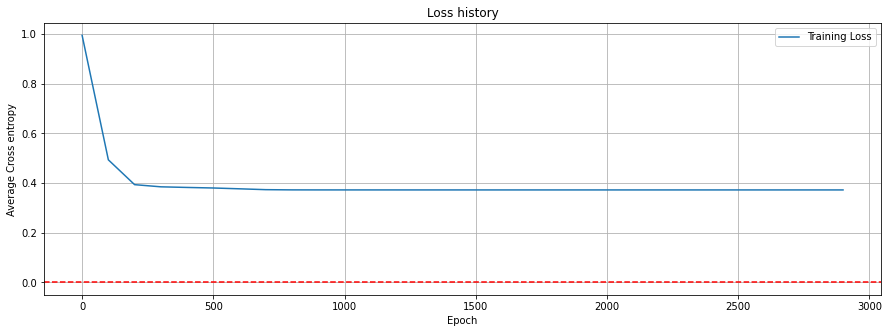

In [83]:
myqcnn.train(lr, epochs, np.arange(n_states), losses.hinge, circuit=True, plot=True)

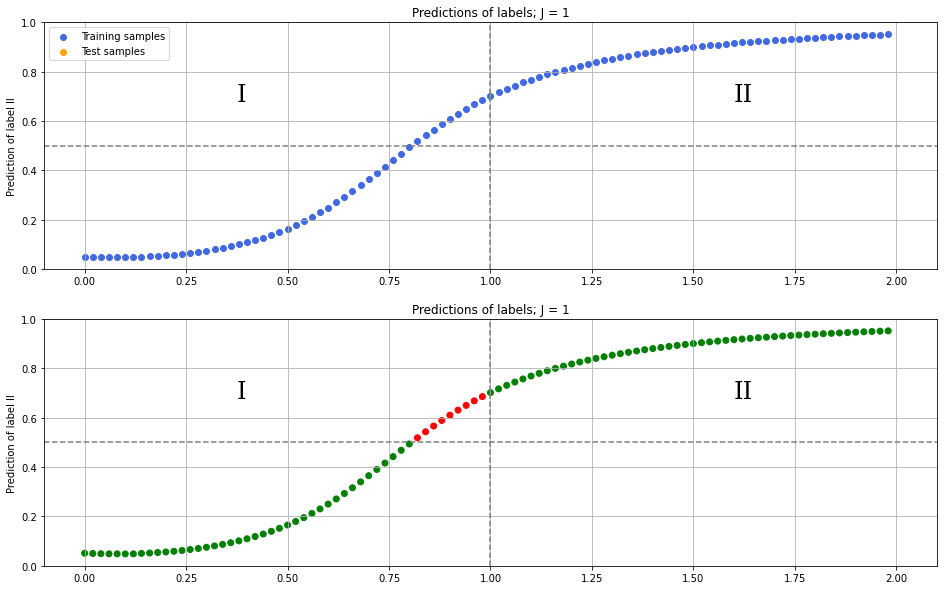

In [84]:
show_QCNN_classification1D(myqcnn)